In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

nitrogen_df = pd.read_csv('Chesapeake_Bay_Pollution_Loads_-_Nitrogen.csv')
nitrogen_df = nitrogen_df.drop(['Land-River Segment', 'FIPS'], axis=1)
nitrogen_df.head()

,County,Tributary Basin,Major Basin,Source Sector,"Total N, 1985 (lb.)","Total N, 2007 (lb.)","Total N, 2009 (lb.)","Total N, 2010 (lb.)","Total N, 2011 (lb.)","Total N, 2012 (lb.)","Total N, 2013 (lb.)","Total N, 2014 (lb.)","Total N, 2015 (lb.)","Total N, 2016 (lb)","Total N Target, 2017 (lb.)",Total N Target 2025 (lb.)
0,ALLEGANY,Upper Potomac,Potomac River Basin,Forest,51155.919440,44291.188480,44013.497320,44071.130370,44127.954830,44065.744140,43439.700190,42644.769650,42279.000080,43150.365480,44567.218760,44936.366390
1,ALLEGANY,Upper Potomac,Potomac River Basin,Non-Tidal Atm,23.744801,11.600470,11.600470,11.600470,11.600470,11.600470,11.600470,11.600470,11.600470,11.600470,11.600469,11.600469
2,ALLEGANY,Upper Potomac,Potomac River Basin,Septic,593.984192,539.573425,534.814819,532.096191,530.284119,527.565125,687.846619,553.043579,547.539978,542.895386,466.803913,421.463309
3,ALLEGANY,Upper Potomac,Potomac River Basin,Stormwater,4163.487261,2510.113876,2473.745250,2463.564675,2455.817180,2456.445068,5187.855037,2569.293440,2718.073060,2686.010203,2278.617397,2148.532161
4,ALLEGANY,Upper Potomac,Potomac River Basin,Wastewater,153.179901,54.931515,298.770703,111.263986,113.858285,101.050881,93.216107,170.578984,0.902378,68.777241,160.712233,68.673253


precipitation trends in Mayrland

http://marylandclimateandweather.weathertogether.net/maryland-statewide-average-precipitation-1895-2017/

Guidelines for the project

https://mde.maryland.gov/programs/Water/TMDL/TMDLImplementation/Pages/overview.aspx

Will Maryland meet the projects set for itself by 2025?

Show how much each sector has decreased over time 

In [4]:
# nitrogen_df['Major Basin'].unique()

array(['Potomac River Basin', 'Western Shore of Chesapeake Bay',
       'Patuxent River Basin', 'Eastern Shore of Chesapeake Bay',
       'Susquehanna River Basin'], dtype=object)

Here we are cleaning the data set in order to do analysis later. We removed Land-River Segment and FIP because they are not necessary for our analysis (should we explain why they are not necessary?). Then we use the pandas features melt to change the format of the data from horizontal to verticle.


In [3]:
import re

temp_dict = {}
for column in nitrogen_df.columns[4:]:
    temp_dict[column] = re.findall("\d{4}", column)[0]


nitrogen_df = nitrogen_df.rename(columns=temp_dict)
nitrogen_df = pd.melt(nitrogen_df,id_vars=['County','Tributary Basin','Major Basin','Source Sector'], \
                      var_name='Year', value_name='Total lbs.')

In [4]:
nitrogen_df = nitrogen_df.set_index("Major Basin")
nitrogen_df.drop(['Potomac River Basin', 'Patuxent River Basin','Susquehanna River Basin'],axis=0,inplace=True)
nitrogen_df = nitrogen_df.reset_index()
nitrogen_df = nitrogen_df.set_index("Tributary Basin")
nitrogen_df.drop(['Patapsco/Back', 'Patuxent'],axis=0,inplace=True)
nitrogen_df = nitrogen_df.reset_index()
nitrogen_df.head()

,Tributary Basin,Major Basin,County,Source Sector,Year,Total lbs.
0,Lower Western Shore,Western Shore of Chesapeake Bay,ANNE ARUNDEL,Agriculture,1985,416.321233
1,Lower Western Shore,Western Shore of Chesapeake Bay,ANNE ARUNDEL,Forest,1985,8764.888672
2,Lower Western Shore,Western Shore of Chesapeake Bay,ANNE ARUNDEL,Non-Tidal Atm,1985,622.435425
3,Lower Western Shore,Western Shore of Chesapeake Bay,ANNE ARUNDEL,Septic,1985,62891.738280
4,Lower Western Shore,Western Shore of Chesapeake Bay,ANNE ARUNDEL,Stormwater,1985,60435.638230


In [5]:
nitrogen_df.shape

(21312, 6)

Ignore results for 2017 and 2025 because those were predictions that the reseachers made. The only measured values are 2007-2016

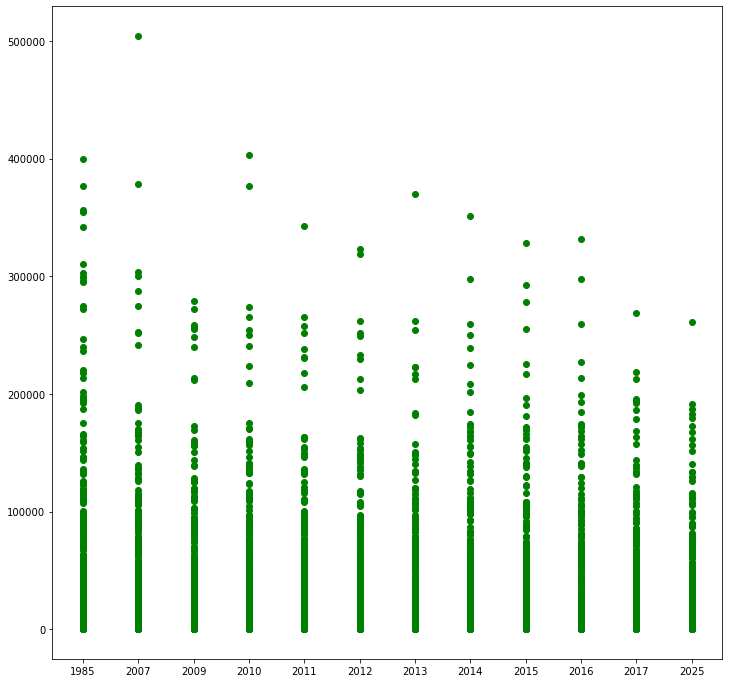

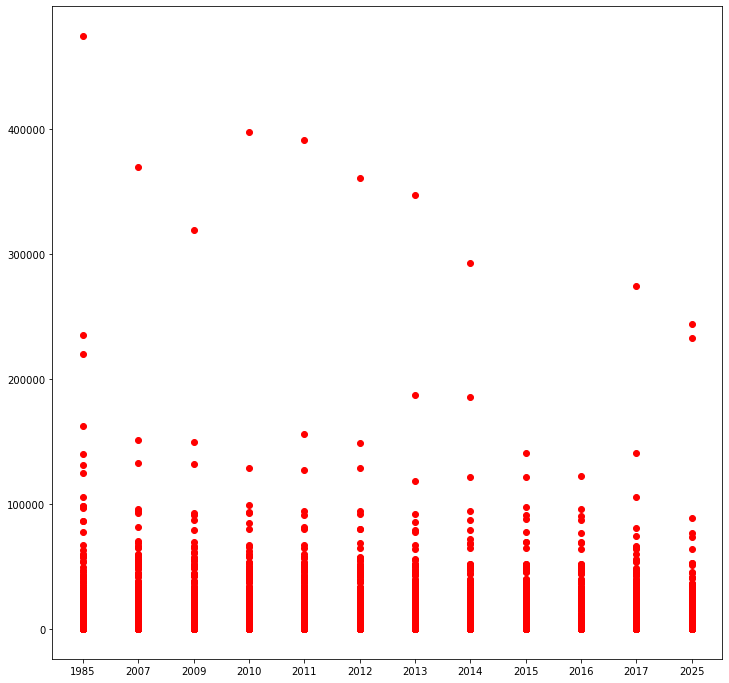

In [14]:
fig = plt.figure(figsize = (12, 12))
eastern_shore = nitrogen_df[nitrogen_df['Major Basin'] == 'Eastern Shore of Chesapeake Bay']
western_shore = nitrogen_df[nitrogen_df['Major Basin'] == 'Western Shore of Chesapeake Bay']
plt.scatter(eastern_shore['Year'], eastern_shore['Total lbs.'], c = "green")
fig = plt.figure(figsize = (12, 12))
plt.scatter(western_shore['Year'], western_shore['Total lbs.'], c = "red")

In [39]:
phosphorus_df = pd.read_csv('Chesapeake_Bay_Pollution_Loads_-_Phosphorus.csv')
phosphorus_df = phosphorus_df.drop(['Land-River Segment', 'FIPS'], axis=1)

In [40]:
temp_dict = {}
#changes Total P, #### (lb.) -> ####
for column in phosphorus_df.columns[4:]:
    temp_dict[column] = re.findall("\d{4}", column)[0]


phosphorus_df = phosphorus_df.rename(columns=temp_dict)
phosphorus_df = pd.melt(phosphorus_df,id_vars=['County','Tributary Basin','Major Basin','Source Sector'], var_name='Year', value_name='Total lbs.')

<AxesSubplot:xlabel='Year', ylabel='Total lbs.'>

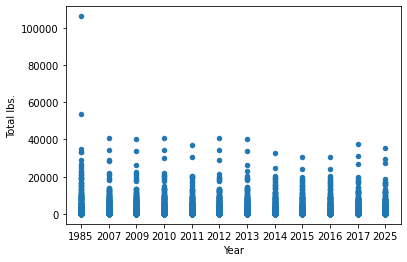

In [41]:
# phosphorus_df.plot.scatter(x='Year',y='Total lbs.', c='DarkBlue')
phosphorus_df[phosphorus_df['Major Basin'] == "Eastern Shore of Chesapeake Bay"].plot.scatter(x='Year',y='Total lbs.')

In [18]:
algae_df = pd.read_csv('LivingResourcesReportedStation.csv', low_memory =False, parse_dates=True)
# algae_df.LatinName.unique()
algae_df.head()

,Source,SampleType,Station,SampleDate,Layer,SampleNumber,GMethod,TSN,LatinName,Size,Method,Parameter,ReportingValue,ReportingUnit,NODCCode,SPECCode
0,MSU/PEARL,C,LE1.1,1/10/2000,AP,FS5,7,1455,Ochromonas,Not Applicable,PH101,COUNT,1399780.0,L,4020103,625
1,MSU/PEARL,C,LE1.1,1/10/2000,AP,FS5,7,1791,Apedinella radians,Not Applicable,PH101,COUNT,82340.0,L,405040301,879
2,MSU/PEARL,C,LE1.1,1/10/2000,AP,FS5,7,2160,Chrysochromulina,Not Applicable,PH101,COUNT,82340.0,L,6030101,603
3,MSU/PEARL,C,LE1.1,1/10/2000,AP,FS5,7,2288,Centrales,<10 Microns,PH101,COUNT,823400.0,L,702,174
4,MSU/PEARL,C,LE1.1,1/10/2000,AP,FS5,7,2402,Skeletonema costatum,Not Applicable,PH101,COUNT,15068220.0,L,702020101,136


In [8]:
prorocentrum_minimum = algae_df[algae_df['LatinName'] == 'Prorocentrum minimum'].copy(deep=True).reset_index()

In [9]:
year = []
for date in prorocentrum_minimum.SampleDate:
    year.append(date[-2:])
prorocentrum_minimum['Year'] = year
prorocentrum_minimum

,index,Source,SampleType,Station,SampleDate,Layer,SampleNumber,GMethod,TSN,LatinName,Size,Method,Parameter,ReportingValue,ReportingUnit,NODCCode,SPECCode,Year
0,179,MSU/PEARL,C,CB5.2,1/18/2000,AP,FS5,7,9880,Prorocentrum minimum,Not Applicable,PH101,COUNT,54893.0,L,1202010402,375,00
1,195,MSU/PEARL,C,CB3.3C,1/19/2000,AP,FS5,7,9880,Prorocentrum minimum,Not Applicable,PH101,COUNT,1152760.0,L,1202010402,375,00
2,215,MSU/PEARL,C,CB4.3C,1/19/2000,AP,FS5,7,9880,Prorocentrum minimum,Not Applicable,PH101,COUNT,576380.0,L,1202010402,375,00
3,351,MSU/PEARL,C,CB2.2,1/20/2000,WC,FS7,7,9880,Prorocentrum minimum,Not Applicable,PH101,COUNT,98808.0,L,1202010402,375,00
4,379,ODU/PEL,C,SBE5,1/21/2000,AP,FS1,7,9880,Prorocentrum minimum,Not Applicable,PH102,COUNT,13696.0,L,1202010402,375,00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3813,222513,ODU/PEL,C,CB7.3E,12/13/2018,BP,FS1,7,9880,Prorocentrum minimum,Not Applicable,PH103,COUNT,291264.0,L,1202010402,375,18
3814,222559,ODU/PEL,C,CB7.4,12/13/2018,AP,FS1,7,9880,Prorocentrum minimum,Not Applicable,PH103,COUNT,866688.0,L,1202010402,375,18
3815,222609,ODU/PEL,C,CB7.4,12/13/2018,BP,FS1,7,9880,Prorocentrum minimum,Not Applicable,PH103,COUNT,157035.8,L,1202010402,375,18
3816,222655,ODU/PEL,C,LE3.6,12/13/2018,AP,FS1,7,9880,Prorocentrum minimum,Not Applicable,PH103,COUNT,816960.0,L,1202010402,375,18


<AxesSubplot:xlabel='Year', ylabel='ReportingValue'>

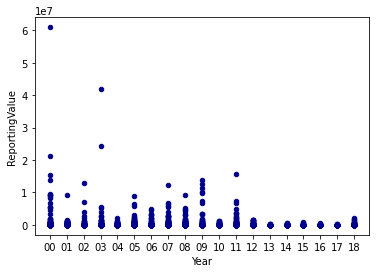

In [10]:
prorocentrum_minimum.plot.scatter(x='Year',y='ReportingValue', c='DarkBlue')

https://www.cbf.org/how-we-save-the-bay/chesapeake-clean-water-blueprint/the-history-of-bay-cleanup-efforts.html
This link may explain why there is a general decrease in prorocentrum minimum over the years

In [13]:
blue_green_sphere = algae_df[algae_df['LatinName'] == 'Blue green sphere'].copy(deep=True).reset_index()
year = []
for date in blue_green_sphere.SampleDate:
    year.append(date[-2:])
blue_green_sphere['Year'] = year
blue_green_sphere.head()

,index,Source,SampleType,Station,SampleDate,Layer,SampleNumber,GMethod,TSN,LatinName,Size,Method,Parameter,ReportingValue,ReportingUnit,NODCCode,SPECCode,Year
0,39,ODU/PEL,C,RET4.3,1/12/2000,AP,FS1,7,0,Blue green sphere,Sphere,PH102,COUNT,1369600.0,L,3,815,00
1,40,ODU/PEL,C,RET4.3,1/12/2000,AP,FS1,7,0,Blue green sphere,Trichome,PH102,COUNT,273920.0,L,3,816,00
2,41,ODU/PEL,C,RET4.3,1/12/2000,AP,FS1,7,0,Blue green sphere,Trichome B,PH102,COUNT,602624.0,L,3,1349,00
3,65,ODU/PEL,C,RET4.3,1/12/2000,BP,FS1,7,0,Blue green sphere,Sphere,PH102,COUNT,962979.0,L,3,815,00
4,66,ODU/PEL,C,RET4.3,1/12/2000,BP,FS1,7,0,Blue green sphere,Trichome,PH102,COUNT,283229.0,L,3,816,00


<AxesSubplot:xlabel='Year', ylabel='ReportingValue'>

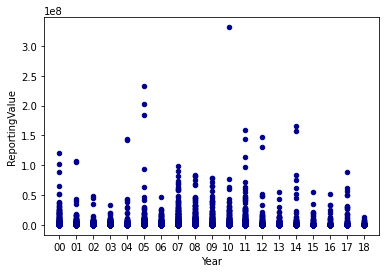

In [14]:
blue_green_sphere.plot.scatter(x='Year',y='ReportingValue', c='DarkBlue')

In [22]:
oxygen_levels = pd.read_csv('AN_OCEAN_2016-2018.csv')

In [23]:
oxygen_levels.head()

,Time (UTC) (Dd-MMM-yyyy HH:mm:ss),Year,Latitude (Degrees East),Longitude (Degrees North),Temperature (Degrees Celsius),Salinity (practical salinity unit),Chlorophyll (Micrograms per Liter),Turbidity(Nephelometric Turbidity Units),Oxygen (millilitres O2 per liter),Significant wave height (meters),Wave from direction (Degrees clockwise from due north),Wave period (seconds),North surface currents (meters/second),East surface currents (meters/second)
0,3/23/2016,2016,38.963675,-76.446862,NaN,0.8,3.0,10.7,9.1,0.3,96.2,4.9,-77.18,92.42
1,3/23/2016,2016,38.963667,-76.446875,NaN,NaN,1.9,NaN,NaN,0.1,156.0,1.9,-77.21,92.48
2,3/23/2016,2016,38.963670,-76.446870,9.8,9.1,3.1,2.5,11.3,0.2,154.0,2.1,-30.60,142.98
3,3/23/2016,2016,38.963677,-76.446867,9.6,9.2,3.0,2.3,11.0,0.1,164.0,1.9,-45.59,136.59
4,3/23/2016,2016,38.963672,-76.446862,9.3,9.3,4.4,2.3,11.0,0.2,167.0,2.1,-7.14,58.01


<AxesSubplot:xlabel='Year', ylabel='Oxygen (millilitres O2 per liter)'>

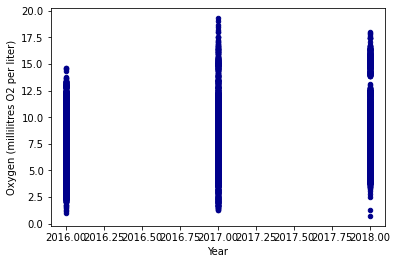

In [24]:
oxygen_levels.plot.scatter(x='Year',y='Oxygen (millilitres O2 per liter)', c='DarkBlue')